# DEFINICIÓN DE PARÁMETROS

In [1]:
#######################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = './data/700Train.csv'
validation_file_relative = './data/700Validation.csv'
test_file_relative = './data/700Test.csv'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_masked'
edited_dir_relative = '../local/output_edited'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#######################################################################################################################

# DEFINICIÓN PARÁMETROS CNN

In [2]:
#######################################################################################################################

EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

IMG_HEIGHT = IMG_WIDTH = 448

#######################################################################################################################

In [3]:
import os
import platform

import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

from modules.dataset_utils import DatasetUtils

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
edited_dir = os.path.abspath(edited_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('==============================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t\t' + ai4utils)
print('CameraTraps PATH: ' + '\t\t' + CameraTraps)
print('Train CSV PATH: ' + '\t\t' + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t\t\t' + test_file)
print('masked PATH: ' + '\t\t\t' + masked_dir)
print('edited PATH: ' + '\t\t\t' + edited_dir)
print('models PATH: ' + '\t\t\t' + model_dir)
print('==============================================================================================================')


TensorFlow version: 2.10.0
Is GPU available? tf.test.is_gpu_available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PYTHONPATH: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Train.csv
Validation CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Validation.csv
Test CSV PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Test.csv
masked PATH: 			/Users/carlos/WORKSPACE/local/output_masked
edited PATH: 			/Users/carlos/WORKSPACE/local/output_edited
models PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models


# Generate Datasets

In [4]:
custom = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
)

general = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

file_names, labels = DatasetUtils.load_dataset(train_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
train_df = pd.DataFrame(data=d, dtype=str)
train_dataset = custom.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)
from collections import Counter
itemCt = Counter(train_dataset.classes)
maxCt = float(max(itemCt.values()))
cw = {clsID : maxCt/numImg for clsID, numImg in itemCt.items()}

file_names, labels = DatasetUtils.load_dataset(validation_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
validation_df = pd.DataFrame(data=d, dtype=str)
validation_dataset = general.flow_from_dataframe(
    dataframe=validation_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

file_names, labels = DatasetUtils.load_dataset(test_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
test_df = pd.DataFrame(data=d, dtype=str)
test_dataset = general.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 1450 validated image filenames belonging to 2 classes.
Found 312 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.


# ResNet 34 Architecture

In [5]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape=(32, 32, 3), classes=10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size * 2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
    return model


ResNet = ResNet34(shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=1)

ResNet.summary()

ResNet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[keras.losses.BinaryCrossentropy()],
    metrics=['accuracy'])

Metal device set to: Apple M1


2022-10-18 19:41:08.645373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 19:41:08.645466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 454, 454, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 227, 227, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

Epoch 1/50


2022-10-18 19:41:09.876057: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 19:41:11.595759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 1.4893 - accuracy: 0.6632

2022-10-18 19:43:24.165526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 141s 1s/step - loss: 1.4893 - accuracy: 0.6632 - val_loss: 0.9616 - val_accuracy: 0.6579
Epoch 2/50
90/90 [==============================] - 129s 1s/step - loss: 0.5566 - accuracy: 0.6632 - val_loss: 0.7248 - val_accuracy: 0.6579
Epoch 3/50
90/90 [==============================] - 129s 1s/step - loss: 0.4836 - accuracy: 0.6632 - val_loss: 0.7019 - val_accuracy: 0.6579
Epoch 4/50
90/90 [==============================] - 129s 1s/step - loss: 0.5083 - accuracy: 0.6611 - val_loss: 0.6812 - val_accuracy: 0.6579
Epoch 5/50
90/90 [==============================] - 129s 1s/step - loss: 0.4573 - accuracy: 0.6632 - val_loss: 0.7089 - val_accuracy: 0.6579
Epoch 6/50
90/90 [==============================] - 130s 1s/step - loss: 0.5296 - accuracy: 0.6625 - val_loss: 0.3235 - val_accuracy: 0.6678
Epoch 7/50
90/90 [==============================] - 130s 1s/step - loss: 0.4600 - accuracy: 0.6618 - val_loss: 0.5872 - val_accuracy: 0.6612
Epoch 8/50
90/90 [======

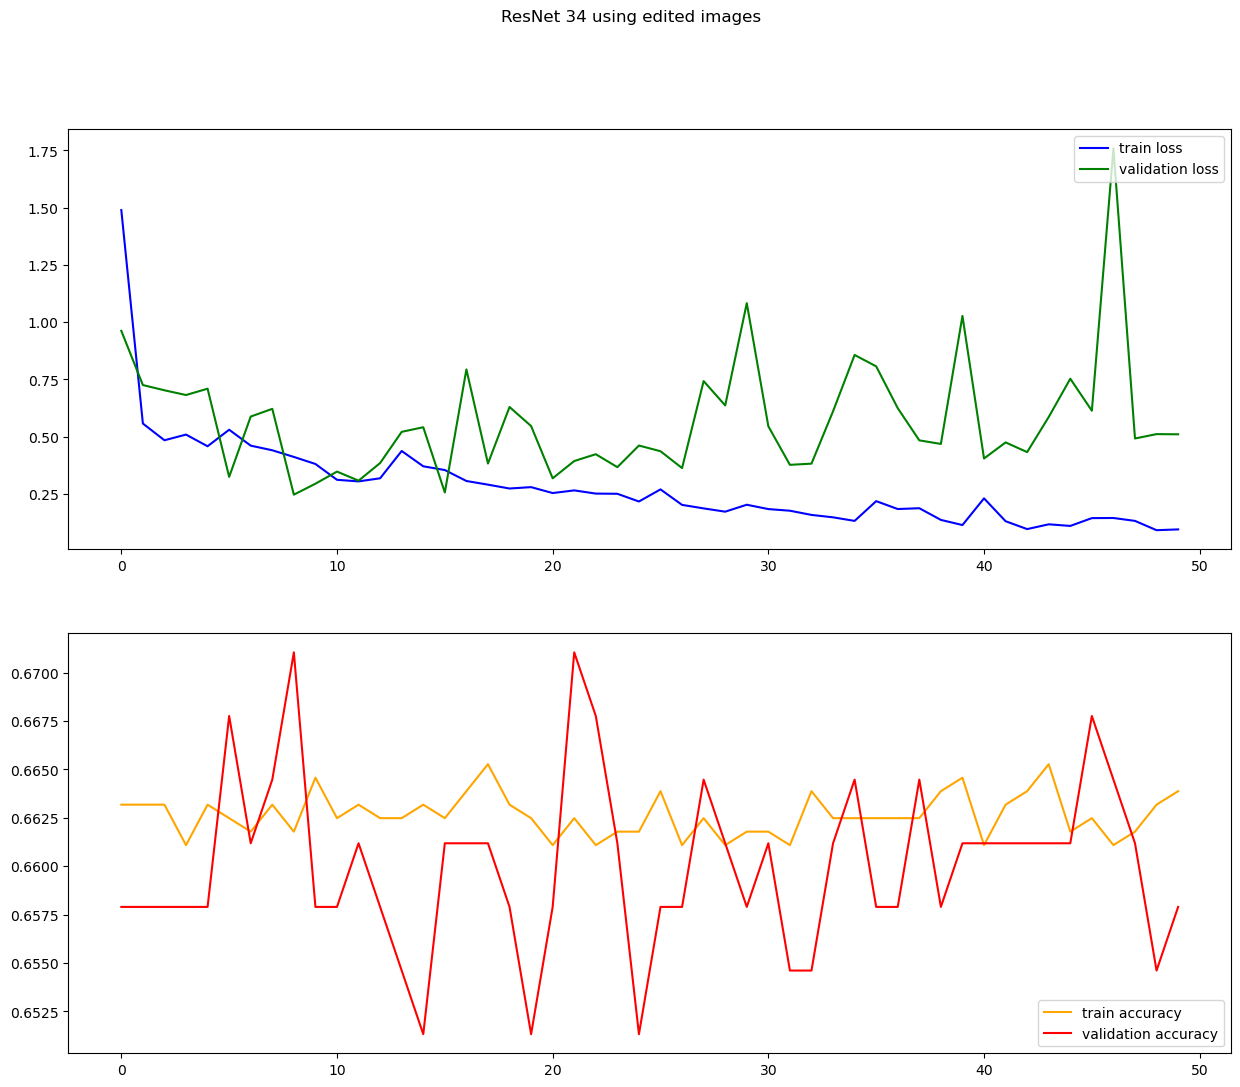

In [6]:
hist = ResNet.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // BATCH_SIZE,
    class_weight=cw,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // BATCH_SIZE,
    verbose=1
)
results = ResNet.evaluate(
    test_dataset,
    batch_size=BATCH_SIZE,
    verbose=1
)

fig = plt.figure(figsize=(15, 12))
fig.suptitle('ResNet 34 using edited images')

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(hist.history['loss'], color='blue', label='train loss', )
ax1.plot(hist.history['val_loss'], color='green', label='validation loss')
ax1.legend(loc="upper right")
ax2.plot(hist.history['accuracy'], color='orange', label='train accuracy')
ax2.plot(hist.history['val_accuracy'], color='red', label='validation accuracy')
ax2.legend(loc="lower right")
plt.show()